#  SN1987A:  MIRISim (MRS IFU)

#### This notebook replicates the MIRI MRS IFU spectroscopy part of the SN 1987A: The Formation and Evolution of Dust in a Supernova Explosion JWST GTO programme (#1232). 

Details of generating ETC and APT files in this example science program can be found on the JDoX webpages: https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-example-science-programs/miri-mrs-and-nirspec-ifu-observations-of-sn1987a

**Science Objective:** 
The main science goals of this project are to understand how massive stars age and explode, how their ejecta form dust and molecules, and how the blast wave from their violent explosion affects their surroundings. JWST MIRI imaging, and medium resolution spectroscopy (MRS) will provide key emission line diagnostics and dust feature and continuum measurements of SN 1987A. The central stellar ejecta of SN 1987A is surrounded by a ring of progenitor gas and dust that is being shocked by the blast wave of the explosion. A large quantity (0.4–0.7 solar masses; Matsuura et al. 2011) of dust in the stellar ejecta has an unknown composition, and these observations may provide the first constraints through imaging and spatially resolved spectroscopy.  The **MRS IFU** spectroscopy will measure key shocked line diagnostics that will further constrain the shock physics as well as the elemental abundances in both the ring and the stellar ejecta. 

**In this notebook**, we create a scene with a cold blackbody ~ 20K replicating the inner ejecta of SN 1987A and a ring of warm (~ 100K) silicate dust and atomic emission lines surrounding the ejecta that all fit within the MRS field of view, and run through a MIRISim simulation showing the products created at each stage.

**NOTE** this notebook must be started within  the correct anaconda environment in which you have MIRISim installed. This is a prerequisite for using MIRISim, and installation instructions can be found [here](http://miri.ster.kuleuven.be/bin/view/Public/MiricleInstallation).

When launching the notebook, make sure in the right Anaconda environment. i.e. type


<code> source activate miricle </code> 

in the terminal before starting the notebook.

### Steps in this notebook:

0. Import useful python packages
1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.  

## Step 0 - Some general python housekeeping
### Import useful python packages

In [1]:
# Import usefull python packages
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt    
from matplotlib import colors,cm
%matplotlib inline       

######################################
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation         

### Define some common functions 

1) <code>save_to_fits</code> - Used to save the generated scene to a fits file

2) <code>show_outputs</code> - Used in plotting outputs from MIRISim

3) <code>row_based_idx</code> - Used to fill matplotlib subplots by column, not row

4) <code>show_skycubes_spec</code> - Used to plot the spectrum in datacubes generated by MIRISim

In [2]:
def save_to_fits(scene, light_path, filename='MIRISim_scene.fits', SpatialSampling=0.1, WavelengthRange=None, 
                 WavelengthSampling=0.1):
    """
    Function to save the MIRISim scene to a fits file.
    
    :param filename: Name of file to save - default is "MIRISim_scene.fits"
    :type filename: string       
    
    :param SpatialSampling: Spatial sampling (in arcsec) - default is 0.1 arcseconds
    :type SpatialSampling: float
    
    :param WavelengthRange: Wavelength range to process (in microns) - default is [5, 28] microns
    :type WavelengthRange: array
    
    :param WavelengthSampling: Channel width (in microns) - default is 0.1 arcseconds
    :type WavelengthSampling: float
    
    :rtype: None
    :raises Exception: when light_path parameter not set to MRS or IMA
    """
    
    # Avoids array being extended inside function for mutliple calls. Python gotcha
    if WavelengthRange is None:
        WavelengthRange = [5, 28]
        
    if light_path == 'IMA':
        # IMA Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-57., 57.],[-57., 57.]])   
    elif light_path == "MRS":
        # MRS Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-4., 4.],[-4., 4.]])       
    else:
        raise Exception('Acceptable inputs for parameter light_path are [IMA] and [MRS]')
    
    # overwrite = True enables overwriting of any previous version of the fits file
    # with the same name as that given in the writecube command
    scene.writecube(cubefits = filename,
                    FOV = FOV, time = 0.0,
                    spatsampling = SpatialSampling,
                    wrange = WavelengthRange,
                    wsampling = WavelengthSampling,
                    overwrite = True) 

In [3]:
def show_outputs(MIRISim_outputdir,output_type):
    """
    Plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    """
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis, aspect='equal')
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
    else:
        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data
            
        
        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest', aspect='equal')
        plt.title('{}'.format(infits.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')

    plt.colorbar()

In [4]:
def row_based_idx(num_rows, num_cols, idx):
    """
    Function to fill matplotlib subplots by column, not row
    """
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

In [5]:
def show_skycubes_spec(directory_list):
    """
    Plots the average MIRISim spectra for each FOV from the 12 skycubes generated from 
    the Short, Medium and Long dispersers
    :param directory_list:  
        List contaning the three output directories for the MRS simulation results
    """    
    
    # Define subplot grid for the MRS skycubes
    num_cols = 3 
    num_rows = 4             

    maxfigs = 12
    fig = plt.figure(figsize=(10,3*num_rows))
    i=0

    for num, outputdir in enumerate(directory_list):
        outputDirContents = os.listdir(outputdir)

        directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]

        #print('\nFor the {} the output directory is: {} '.format(sim_filenames[num], outputdir))
        #print('This directory contains four skycubes which cover the wavelength ranges:')

        filenames_skycube = glob.glob('{}/{}/*.fits'.format(outputdir,'skycubes')) # Get skycube file

        for skycube_file in filenames_skycube:

            hdu = fits.open(skycube_file)        # Open file 
            data_cube = hdu[0].data              # Get data 
            #datashape = hdu[0].data.shape       # Get data shape - Z, X, Y  

            # Get the wavelength data 
            wav =  hdu[1].data

            # Find the max and min wavelelgths for the output cube
            vmin = wav[0]
            vmax = wav[-1]       
            #print(np.round(vmin,2), np.round(vmax,2))

            # Get the flux data from an average of the cube
            spectrum = data_cube.mean(axis=(1, 2))  

            # Plot the spectrum - Each colum = short, medium, long
            plt.subplot(num_rows, num_cols, row_based_idx(num_rows, num_cols,i+1))
            plt.plot(wav, spectrum)                                       
            #plt.xticks([])  # help clean up the plot
            plt.yticks([])   # help clean up the plot 
            i+=1    

    fig.add_subplot(111, frame_on=False)

    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Wavelength (microns)", fontsize=14)
    plt.ylabel("Flux (data units)", fontsize=14)

    fig.suptitle('    Short                           Medium                           Long', y=1.02, fontsize=18)

    fig.tight_layout()

    plt.show()
    plt.close()    

### Set flags for saving the MIRISim scene to a fits file - default is False 
We select false as the default as 1) a fits file of the scene is not necessary to run mirisim; 2) this step can take a long time to run; 3) once a scene has been saved as a fits file one this step is not necessary.

In [6]:
save_scene_as_fits = False

## Step 1 - Create a Scene - this represents your science observation

Each scene should include at minimum: 1) A background level; 2) A science source

The scene created below consists of a cold ~ 20K blackbody replicating the inner ejecta of SN1987A and a ring of warm silicate dust surrounding the ejecta that all of which fit within the MRS field of view. The first point source has a 20 K blackbody SED, the ring has a SED imported from Spitzer IRS observations. 



#### Create a low level background for the scene

In [7]:
bg = Background(level='low',gradient=9., pa=45.)

2021-04-27 16:37:55,112 - INFO - Initializing Background


#### Create the First Point Source - replicating the cold (~20 K) dust in the inner ejecta - Flux values and tempratures from Matsuura et al. 2011



In [8]:
# Initialise a single point source at the central position of the MIRI MRS
"""
MIRI MRS FOV     = 3.7 × 3.7  arcseconds  in ALL four channels 
Max MIRI MRS FOV = 7.2 × 7.9  arcseconds  
"""
point1 = Point(Cen = (0.0,0.0))

# Set properties of the SED for point 1
Blackbody = sed.BBSed(Temp = 26., wref = 20., flux = 45.4 * 1000)  # Temp = K, wref = microns, flux = micro Jy 

# Add the SED to the point source
point1.set_SED(Blackbody)

# Add ejecta (point1) to the compound target list called 'sn1987A_components' for creating a scene
sn1987A_components = point1

# For writing to scene.ini file
targetlist = [point1]


2021-04-27 16:37:55,121 - INFO - Initializing Point


### Create the ring surrounding the ejecta 

#### 1) First import the SED from an external file

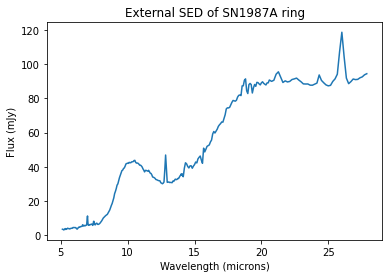

In [9]:
# Get SEDs of the ring for SN1987A observed with Spitzer IRS. Data from Jones et al. 2017b 

# Use: sedfile =  ExternalSed('extsed.txt') # filepath, columns 'wavelength' [microns] and 'flux' [muJy]
ring_sed = ExternalSed(sedfile = 'SN1987A_ring_microJy.txt') 

# For zooming in on spectral ranges
l_min = 5 #micron
l_max = 28 #micron
sp_min = np.abs(ring_sed.Lam-l_min).argmin()
sp_max = np.abs(ring_sed.Lam-l_max).argmin()

# Plot the Spitzer spectrum of the SN1987A ring component for refrence
fig = plt.figure(figsize=(8, 6))
ax = plt.subplots()[1]  
ax.plot(ring_sed.Lam[sp_min:sp_max], ring_sed.fLam[sp_min:sp_max])   
ax.set_xlabel("Wavelength (microns)")  
ax.set_ylabel("Flux (mJy)")  
ax.set_title("External SED of SN1987A ring")  
plt.close(fig)

#### 2) Then attach the SED to an object

In [10]:
# Set up the spatial distibution of the ring of SN1987A

# Create a ring of sources and add them to the scene
MRS_radius = 3.2/2.   # Radius of MRS (in arcsec)             
Nring = 16            # Number of ring components to put within the MRS 

# Create a circle of resolved objects to replicate the ring, add the SED to each object and add to the scene
for i in range(0,Nring):
      
    xp = np.cos(2*np.pi/Nring*i)*MRS_radius
    yp = np.sin(2*np.pi/Nring*i)*MRS_radius
    
    # Initlise a ring using the galaxy template of a non-pointsource 
    ring = Galaxy(Cen = (xp,yp),n=0.5,re=0.15,q=0.33,pa=360/Nring*i)  # n = sersic idx; re = eff. rad. [arcsec] ; q = axis ratio
 
   
#     # Test to work out why ring galaxy object causing simulation to crash
    
#     # set the properties of the SED
#     ring_sed = sed.PLSed(alpha=1.0,flux=5e5,wref=10.)
#     # add the SED to the galaxy
#     ring.set_SED(ring_sed)
    
    
#     # create a velocity mapping for the SED
#     VMAPpars = {'vrot': 200., 'Cen': (0., -0.5), 'pa': 90., 'q': 0.1, 'c': 0}
#     VelocityMap = kinetics.FlatDisk(**VMAPpars)
#     # add the velocity map to the galaxy
#     ring.set_velomap(VelocityMap)
    
#     # add a line of sight velocity distribution to the galaxy
#     losVeloDist = kinetics.Losvd(sigma=200.,h3=0.,h4=0.)
#     ring.set_LOSVD(losVeloDist)
    
    # Add the Spitzer IRS observtions of the ring from Jones et al 2017b to generate the SED of initialised ring
    ring.set_SED(ring_sed)

    sn1987A_components += ring    # For creating a scene
    targetlist.append(ring)       # For writing to scene.ini file

2021-04-27 16:37:55,324 - INFO - Initializing Galaxy
2021-04-27 16:37:55,325 - INFO - Initializing Galaxy
2021-04-27 16:37:55,326 - INFO - Initializing Galaxy
2021-04-27 16:37:55,326 - INFO - Initializing Galaxy
2021-04-27 16:37:55,327 - INFO - Initializing Galaxy
2021-04-27 16:37:55,328 - INFO - Initializing Galaxy
2021-04-27 16:37:55,328 - INFO - Initializing Galaxy
2021-04-27 16:37:55,329 - INFO - Initializing Galaxy
2021-04-27 16:37:55,329 - INFO - Initializing Galaxy
2021-04-27 16:37:55,330 - INFO - Initializing Galaxy
2021-04-27 16:37:55,331 - INFO - Initializing Galaxy
2021-04-27 16:37:55,332 - INFO - Initializing Galaxy
2021-04-27 16:37:55,332 - INFO - Initializing Galaxy
2021-04-27 16:37:55,333 - INFO - Initializing Galaxy
2021-04-27 16:37:55,334 - INFO - Initializing Galaxy
2021-04-27 16:37:55,335 - INFO - Initializing Galaxy
2021-04-27 16:37:55,335 - INFO - Initializing Galaxy
2021-04-27 16:37:55,336 - INFO - Initializing Galaxy
2021-04-27 16:37:55,336 - INFO - Initializing 

### From the components, create a scene

To create a scene adding together the background and targets i.e the ejecta component and the ring components.

In [11]:
scene = bg +  sn1987A_components

### Export the scene to an ini file and FITS file (optional)

Export scene to an ini file (for future use), or a FITS file to be visualised. This stage is not necessary if runing mirisim in a notebook.

Exporting to a FITS file requires specifing a number of aditional parametrs such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)


In [12]:
# Used to run MIRISim within notebook
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

# Export to ini file - not necessary if runing mirisim in notebook
os.system('rm -fr MRS_SN1987A_scene.ini')      # Remove previous version of .ini file
scene_config.write('MRS_SN1987A_scene.ini')

##### OPTIONAL - Save the generted scene to a fits file - Note this step can take a long time depening on the chosen perameters

In [13]:
# Export to FITS file - Optional 
if save_scene_as_fits == True:
    save_to_fits(scene, light_path="MRS", filename='MIRISim_scene.fits')

## Initialise the MRS Simulation Parameters

This is where the parameters for the MRS simulation get set.  These should be set to match the desired MIRI observation setup. 

**Note** MIRISim must have perameters set for all light paths in <code>SimConfig.makeSim</code> this includes some perameters not relevent to the MRS simulation defined in this file. Those perameters not being used in this simulation are labelled with <code> NOT USED HERE </code> in the comments of each line **and should not be deleted**.

### SN1987A MRS obsevation set up:

For SN 1987A we want to simulate a spectrum covering the full MRS 5-28 micron wavelength range.  To replicate this in MIRISim - **3 simulations are needed to obtain a full spectrum** using SHORT MEDIUM and LONG respectively using both the short and long wavelength arms (CH 1 & 2 and CH 3 & 4 respectively).

1. Dither = Extended source 4pt 
2. Read out mode = <code>FAST</code> selected based on best practices.  

#### Desperser  -   Groups - Integrations
- Short:  94 groups and 3 integrations
- Medium: 94 groups and 3 integrations 
- Long:   94 groups and 3 integrations

NB A <code>FAST</code> readout pattern selected due to high dynamic range in flux for the ring and the ejecta. This will prevent sauturaion.

**Note - there is currently a bug in the MRS fars read pattern - to get smething more realisitic in the data output I have switched to a slow read and cut the number of croups to preserve the integration time** 

Read out mode = <code>SLOW</code> - we will use 11 groups giving an integration time of 3152s vs 3130s for <code>FAST</code>



###  To get the full 5-28 micron spectral range this simulation uses all three despersers. 

#### In the MRS observation set up select appropriate values for the three despersers to loop the simulation over. 

The following setup assumes that the user is using the full MRS spectral range. 
Parameters to be adjusted based on your desired observation setup are the: 

* sim_filenames
* mrs_exposure_values
* mrs_integration_values
* mrs_frame_values

In [14]:
# Generate a list of three config names for the simulations 
sim_config_list = ['sim_config_s', 'sim_config_m','sim_config_l']

# Set the file names of the three simulations
sim_filenames = ['MRS_short_SN1987A_simulation', 'MRS_medium_SN1987A_simulation', 'MRS_long_SN1987A_simulation']

# Configure the Optical path (MRS sub-band)  
config_path_list = ['MRS_1SHORT', 'MRS_1MEDIUM', 'MRS_1LONG']

# Which disperser to use (SHORT/MEDIUM/LONG) 
disperser_list = ['SHORT', 'MEDIUM', 'LONG']

# Number of MRS exposures 
mrs_exposure_values = [1,1,1]

# Number of MRS integrations
mrs_integration_values = [3,3,3]

# Number of groups (for MIRI, # Groups = # Frames)
#mrs_frame_values = [93, 93, 93] - when using FAST read
mrs_frame_values = [11, 11, 11]   #  - when using SLOW read

In [15]:
# Now to loop through the three desperser simulation setups 

# Generate combined list of the observation perameters for the three dispersers 
# based on the values imput in the previous cell.
observaton_setup = [
    sim_filenames, config_path_list, disperser_list,
    mrs_exposure_values, mrs_integration_values, mrs_frame_values]

print("SimConfig populated by:")

# Builds a list to contain the sim_obects built in the below loop
sim_objects = list()

# Generates the three simulation objects for the short medium and long and populates 
# the sim_objects list
# Use python zip function to index arrays to minimise potential errors by passing 
# arguments of unequal length 
for (sim_name_el, config_path_list_el, disperser_list_el, 
     mrs_exposer_value_el, mrs_integration_value_el, mrs_frame_values_el) in zip(*observaton_setup):
    
    print ("{} : {} : {} : {} : {} : {}".format(sim_name_el, config_path_list_el,
                                                     disperser_list_el, mrs_exposer_value_el, 
                                                     mrs_integration_value_el, mrs_frame_values_el))
    
    # Add a safety check to make sure each parameter contains values for all the disperser settings. 
    if (len(sim_config_list) != len(sim_filenames) != len(config_path_list) != len(disperser_list) 
        != len(mrs_exposure_values) != len(mrs_integration_values) != len(mrs_frame_values)):
        raise Exception("All three values are not set - Check imputs.")
    
    ############################################################################################
    # This sets up the simulation - adjust values spefific to your observation setup you wish to simulate 
    
    sim_objects.append(SimConfig.makeSim(
        name = sim_name_el,                   # Name given to simulation
        scene = 'MRS_SN1987A_scene.ini',      # Name of scene file to input

        rel_obsdate = 0.0,                    # Relative observation date (0 = launch, 1 = end of 5 yrs)
        POP = 'MRS',                          # Component on which to center (IMA or MRS)
        ConfigPath = config_path_list_el,     # Configure the Optical path (MRS sub-band)

        disperser = disperser_list_el,        # Which disperser to use (SHORT/MEDIUM/LONG)
        detector = 'BOTH',                    # Specify Channel (SW = channels 1,2, LW= channels 3,4, or BOTH)
        #mrs_mode = 'FAST',                             # MRS read mode (default is Fast)
        mrs_mode = 'SLOW',                             # MRS read mode (default is Fast)
        mrs_exposures = mrs_exposer_value_el,          # Number of exposures
        mrs_integrations = mrs_integration_value_el,   # Number of integrations
        mrs_frames = mrs_frame_values_el,              # Number of groups (for MIRI, # Groups = # Frames)

        ############################################################################################
        # This is where you set up your dither parameters - adjust values spefific to your observation 
        
        Dither = False,             # Dither    
        StartInd = 1,               # Start index for dither pattern 
        NDither = 4,                # Number of dither positions 
        DitherPat = 'mrs_recommended_dither.dat', # Dither pattern to use 
        
        
        ############################################################################################
        # These parameters are not used in the MRS simulation and should not be adjusted (or deleted)
        ima_exposures = 0,           # [NOT USED HERE]
        ima_integrations = 16,       # [NOT USED HERE]
        ima_frames = 14,             # [NOT USED HERE]
        ima_mode = 'FAST',           # [NOT USED HERE]
        filter = 'F1000W',           # [NOT USED HERE]
        readDetect = 'BRIGHTSKY'     # [NOT USED HERE]
        ))

SimConfig populated by:
MRS_short_SN1987A_simulation : MRS_1SHORT : SHORT : 1 : 3 : 11
MRS_medium_SN1987A_simulation : MRS_1MEDIUM : MEDIUM : 1 : 3 : 11
MRS_long_SN1987A_simulation : MRS_1LONG : LONG : 1 : 3 : 11


### Export the simulation setup files

Not necessary as saved in mirisim output in the date stamped output directory. Included here as naming each file explicitly for record keeping.  

In [16]:
for sim_object, file_name in zip(sim_objects, sim_filenames):
    os.system('rm {}.ini'.format(file_name))
    sim_object.write("{}.ini".format(file_name))

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.
The last step is to setup the defaults for internal things like CDPs.

In [17]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [18]:
for sim_object in sim_objects:
    mysim = MiriSimulation(sim_object,scene_config,simulator_config)
    mysim.run()

2021-04-27 16:37:55,460 - INFO - MIRISim version: 2.4.0
2021-04-27 16:37:55,461 - INFO - MIRI Simulation started.
2021-04-27 16:37:55,462 - INFO - Output will be saved to: 20210427_163755_mirisim
2021-04-27 16:37:55,462 - INFO - Storing configs in output directory.
2021-04-27 16:37:55,952 - INFO - Reading cosmic ray properties from parameter file /Users/ojones/anaconda3/envs/miricle/lib/python3.8/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2021-04-27 16:37:55,959 - INFO - Reading detector properties from parameter file /Users/ojones/anaconda3/envs/miricle/lib/python3.8/site-packages/miri/simulators/scasim/detector_properties.py
2021-04-27 16:37:56,004 - INFO - Storing dither pattern in output directory.
2021-04-27 16:37:56,006 - INFO - Using $CDP_DIR for location of CDP files: /Users/ojones/Desktop/mirisim_egs/CDP
2021-04-27 16:37:56,007 - INFO - Setting up simulated Observation, with following settings:
2021-04-27 16:37:56,008 - INFO - Configuration Path: MRS_1SHORT


2021-04-27 16:38:28,032 - INFO - Refining done...
2021-04-27 16:38:28,080 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:38:28,196 - INFO - Refining done...
2021-04-27 16:38:28,246 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:38:28,362 - INFO - Refining done...
2021-04-27 16:38:28,410 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:38:28,523 - INFO - Refining done...
2021-04-27 16:38:28,572 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:38:28,688 - INFO - Refining done...
2021-04-27 16:38:28,710 - INFO - Reading 'PSF' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_2SHORT_PSF_07.02.00.fits'
2021-04-27 16:38:50,738 - INFO - Wrote skycube: 20210427_163755_mirisim/skycubes/skycube_seq1_2SHORT.fits
2021-04-27 16:38:50,741 - INFO - Reading 'DISTORTION' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_8B.05.01.fits'
2021-04-27 16:38:51,078 - INFO - Reading 'DI

2021-04-27 16:42:39,914 - INFO - Mapping completed
2021-04-27 16:42:39,915 - INFO - Detector Intensity Array completed.
2021-04-27 16:42:40,299 - INFO - Reading 'FRINGE' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12SHORT_FRINGE_07.02.05.fits'
2021-04-27 16:42:40,405 - INFO - Reading 'PHOTOM' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12SHORT_PHOTOM_8B.04.00.fits'
2021-04-27 16:42:40,506 - INFO - Reading 'GAIN' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12_GAIN_04.00.00.fits'
2021-04-27 16:42:40,526 - INFO - MRS light path simulation finished.
2021-04-27 16:42:40,531 - INFO - Added 1 Cube to output list
2021-04-27 16:42:40,532 - INFO - Added 2 Cube to output list
2021-04-27 16:42:40,681 - INFO - Wrote illumination model: 20210427_163755_mirisim/illum_models/illum_model_seq1_MIRIFUSHORT_12SHORT.fits
2021-04-27 16:42:40,686 - INFO - Starting pySpecSimMiri
2021-04-27 16:42:40,689 - INFO - Simulating setup file

2021-04-27 16:45:24,596 - INFO -   Detector readout mode is SLOW (samplesum=8, sampleskip=1, nframe=1, groupgap=0) 
  with 3 integrations and ngroups=11 defined explicitly.
  Detector subarray mode is FULL.
2021-04-27 16:45:24,597 - INFO - Detector temperature = 6.70 K (which affects dark current and read noise).
2021-04-27 16:45:24,598 - INFO - Cosmic ray environment is SOLAR_MIN.
2021-04-27 16:45:24,598 - INFO - Reading cosmic ray library file: '/Users/ojones/anaconda3/envs/miricle/lib/python3.8/site-packages/miri/simulators/data/cosmic_rays/CRs_SiAs_470_SUNMIN_07.fits'
2021-04-27 16:45:24,654 - INFO - Simulation control flags:
	Quantum efficiency simulation turned OFF.
	Poisson noise simulation turned ON.
	Read noise simulation turned ON.
	Reference pixels simulation turned ON.
	Bad pixels simulation turned ON.
	Dark current simulation turned ON.
	Flat-field simulation turned ON.
	Amplifier bias and gain turned ON.
	Detector non-linearity effects turned ON.
	Detector drift and laten

2021-04-27 16:45:44,165 - INFO - Initializing Galaxy
2021-04-27 16:45:44,187 - INFO - Parsing: galaxy_16
2021-04-27 16:45:44,188 - INFO - Initializing Galaxy
2021-04-27 16:45:44,189 - INFO - Initializing Galaxy
2021-04-27 16:45:44,190 - INFO - Initializing Galaxy
2021-04-27 16:45:44,212 - INFO - Simulating a single pointing.
2021-04-27 16:45:44,216 - INFO - Creating pointing for position 1
2021-04-27 16:45:44,217 - INFO - Creating exposure event for position 1
2021-04-27 16:45:44,219 - INFO - Reading 'DISTORTION' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_8B.05.01.fits'
2021-04-27 16:45:44,536 - INFO - Observation simulation started.
2021-04-27 16:45:44,537 - INFO - Simulating ExposureEvent for pointing 1
2021-04-27 16:45:44,538 - INFO - Simulating MRS exposures for pointing 1
2021-04-27 16:45:44,539 - INFO - Creating skycubes for MRS exposures for pointing 1
2021-04-27 16:45:44,541 - INFO - Reading 'DISTORTION' model from '/Users/ojones/D

2021-04-27 16:47:06,240 - INFO - Refining done...
2021-04-27 16:47:06,276 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,356 - INFO - Refining done...
2021-04-27 16:47:06,390 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,470 - INFO - Refining done...
2021-04-27 16:47:06,505 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,583 - INFO - Refining done...
2021-04-27 16:47:06,618 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,697 - INFO - Refining done...
2021-04-27 16:47:06,731 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,810 - INFO - Refining done...
2021-04-27 16:47:06,845 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:06,925 - INFO - Refining done...
2021-04-27 16:47:06,960 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:47:07,039 - INFO - Refining done...
2021-04-27 16:47:07,056 - INFO - Reading 'PSF' model from '/Users/ojones/De

2021-04-27 16:52:46,205 - INFO - Simulation control flags:
	Quantum efficiency simulation turned OFF.
	Poisson noise simulation turned ON.
	Read noise simulation turned ON.
	Reference pixels simulation turned ON.
	Bad pixels simulation turned ON.
	Dark current simulation turned ON.
	Flat-field simulation turned ON.
	Amplifier bias and gain turned ON.
	Detector non-linearity effects turned ON.
	Detector drift and latency effects not simulated for SLOW readout mode.
2021-04-27 16:52:46,206 - INFO - No output subarray mode. Input subarray mode assumed FULL.
2021-04-27 16:52:46,207 - INFO - Input subarray mode assumed FULL
2021-04-27 16:52:46,210 - INFO - Reading 'MASK' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12_MASK_07.02.01.fits'
2021-04-27 16:52:46,256 - INFO - Reading 'GAIN' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFUSHORT_12_GAIN_04.00.00.fits'
2021-04-27 16:52:46,318 - INFO - Reading DARK model from '/Users/ojones/Desktop/mirisim_egs

2021-04-27 16:53:23,738 - INFO - Parsing: galaxy_2
2021-04-27 16:53:23,740 - INFO - Initializing Galaxy
2021-04-27 16:53:23,740 - INFO - Initializing Galaxy
2021-04-27 16:53:23,741 - INFO - Initializing Galaxy
2021-04-27 16:53:23,762 - INFO - Parsing: galaxy_3
2021-04-27 16:53:23,763 - INFO - Initializing Galaxy
2021-04-27 16:53:23,764 - INFO - Initializing Galaxy
2021-04-27 16:53:23,765 - INFO - Initializing Galaxy
2021-04-27 16:53:23,786 - INFO - Parsing: galaxy_4
2021-04-27 16:53:23,787 - INFO - Initializing Galaxy
2021-04-27 16:53:23,788 - INFO - Initializing Galaxy
2021-04-27 16:53:23,789 - INFO - Initializing Galaxy
2021-04-27 16:53:23,809 - INFO - Parsing: galaxy_5
2021-04-27 16:53:23,811 - INFO - Initializing Galaxy
2021-04-27 16:53:23,813 - INFO - Initializing Galaxy
2021-04-27 16:53:23,814 - INFO - Initializing Galaxy
2021-04-27 16:53:23,836 - INFO - Parsing: galaxy_6
2021-04-27 16:53:23,838 - INFO - Initializing Galaxy
2021-04-27 16:53:23,840 - INFO - Initializing Galaxy
202

2021-04-27 16:54:10,747 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:10,862 - INFO - Refining done...
2021-04-27 16:54:10,911 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,031 - INFO - Refining done...
2021-04-27 16:54:11,080 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,200 - INFO - Refining done...
2021-04-27 16:54:11,251 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,367 - INFO - Refining done...
2021-04-27 16:54:11,416 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,532 - INFO - Refining done...
2021-04-27 16:54:11,581 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,699 - INFO - Refining done...
2021-04-27 16:54:11,748 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:11,865 - INFO - Refining done...
2021-04-27 16:54:11,912 - INFO - Refining due to small radius 0.150000 ...
2021-04-27 16:54:12,028 - INFO - Refining done...


2021-04-27 16:58:02,457 - INFO - Starting Coordinate Transformation
2021-04-27 16:58:13,682 - INFO - Starting pixel projection with cache.
2021-04-27 16:59:27,766 - INFO - Mapping completed
2021-04-27 16:59:27,767 - INFO - Detector Intensity Array completed.
2021-04-27 16:59:28,095 - INFO - Reading 'FRINGE' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_34LONG_FRINGE_07.02.00.fits'
2021-04-27 16:59:28,216 - INFO - Reading 'PHOTOM' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_34LONG_PHOTOM_8B.04.00.fits'
2021-04-27 16:59:28,332 - INFO - Reading 'GAIN' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_34_GAIN_04.00.00.fits'
2021-04-27 16:59:28,355 - INFO - Simulating Detector Mapping for channel ['4'] and band LONG
2021-04-27 16:59:28,356 - INFO - Getting Coefficients and Substitute values
2021-04-27 16:59:28,358 - INFO - Reading 'DISTORTION' model from '/Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_34LONG_DISTOR

2021-04-27 17:00:46,553 - INFO - Creating exposure_data with 1280 rows x 1032 columns plus 11 groups and 3 ints.
2021-04-27 17:00:46,708 - INFO - Simulating 3 integrations.
2021-04-27 17:00:46,717 - WARNING - ***Input flux array contains 6822 negative values.
2021-04-27 17:00:46,779 - INFO - Simulating 11 groups for integration 1.
2021-04-27 17:00:51,150 - INFO - Simulating 11 groups for integration 2.
2021-04-27 17:00:55,484 - INFO - Simulating 11 groups for integration 3.
2021-04-27 17:00:59,755 - INFO - Adding the DARK calibration from /Users/ojones/Desktop/mirisim_egs/CDP/MIRI_FM_MIRIFULONG_SLOW_34_DARK_06.01.00.fits
2021-04-27 17:01:00,095 - INFO - Correcting nonlinearity from MIRI_FM_MIRIFULONG_34LONG_LINEARITY_06.02.00.fits
2021-04-27 17:01:01,230 - INFO - Output subarray undefined or FULL. SUBSTRT=(1,1), SUBSIZE=(1032,1024)
2021-04-27 17:01:01,231 - INFO - WCS keywords defined as CRPIX1=0, CRPIX2=0
2021-04-27 17:01:01,860 - INFO - Exposure time 788.37s (duration 789.42s) 
2021-

## Examine some of the results

Outputs are in a date-labelled directory taking the form  <code>YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

### The results of the MRS simulation for the 5-28 micron range are contained in three directories - one for each disperser 

In [19]:
directory_list = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-3:] # Takes the last three entry found

In [20]:
for num, outputdir in enumerate(directory_list):
    outputDirContents = os.listdir(outputdir)
    
    directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
    files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

    print('\nFor the {} the output directory is: {} '.format(sim_filenames[num], outputdir))
    print('The subdirectories in the {} directory are:\n{}'.format(outputdir,directories))
    print('The files in the output directory are:\n{}'.format(files))


For the MRS_short_SN1987A_simulation the output directory is: 20210427_163755_mirisim 
The subdirectories in the 20210427_163755_mirisim directory are:
['det_images', 'skycubes', 'illum_models']
The files in the output directory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']

For the MRS_medium_SN1987A_simulation the output directory is: 20210427_164543_mirisim 
The subdirectories in the 20210427_164543_mirisim directory are:
['det_images', 'skycubes', 'illum_models']
The files in the output directory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']

For the MRS_long_SN1987A_simulation the output directory is: 20210427_165323_mirisim 
The subdirectories in the 20210427_165323_mirisim directory are:
['det_images', 'skycubes', 'illum_models']
The files in the output directory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']


The files contain the log which was also output to the terminal (<code>mirisim.log</code>) and the .ini files used to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation.

The directories contain various outputs of MIRISim:

* **<code> skycubes </code>** houses a 3D representation of the input scene to the MRS simulation (skycubes are not generated for imager or LRS simulations). This cube has not been processed by MIRISim, it is simply a gridded (spatially and spectrally) version of the input scene.  
* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 


### Viewing a slice of the skycube

Below, we show an image of the central channel of one of the skycubes generated by MIRISim. 

NOTE: The symmetric ring generated in the scene may appear as an ellipse in the sky cube slice. This is due to the aspect ratio and automatic axis functionality in matplotlib.

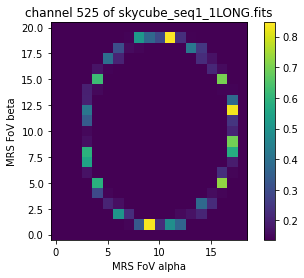

In [21]:
show_outputs(directory_list[2],'skycubes')

### Viewing an averaged spectrum over the full MRS FOV for each disperser and channel of the input scene to the MRS simulation

For the full MRS spectral range a total of **12** **<code>skycubes</code>** are generated by MIRISim- four per disperser. NOTE: These cubes have not been processed by MIRISim. 
Below, we show an average spectum for the input scene across the MRS FOV for each of the 12 **<code>skycubes</code>**. The wavelength ranges of each skycube is also printed. 

NOTE: The fluxes are not normalised between each indivisual plot. 

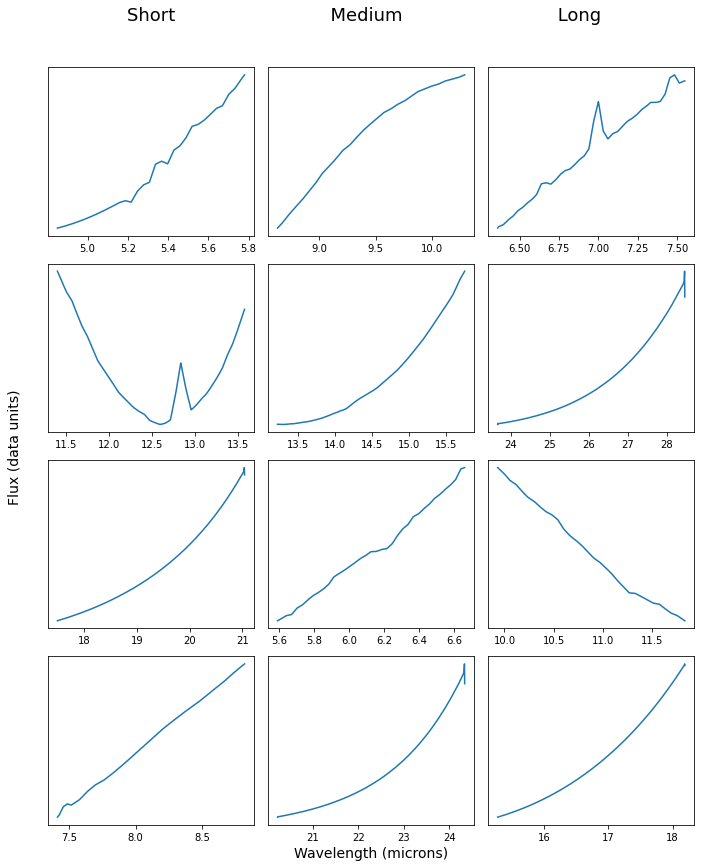

In [22]:
show_skycubes_spec(directory_list)  

## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

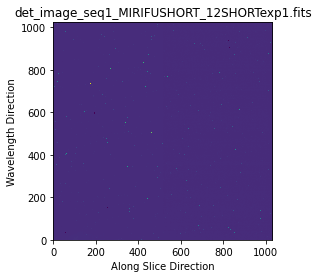

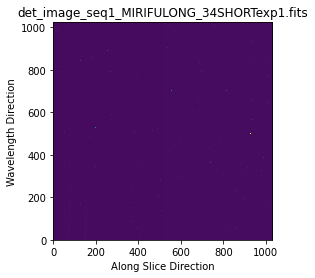

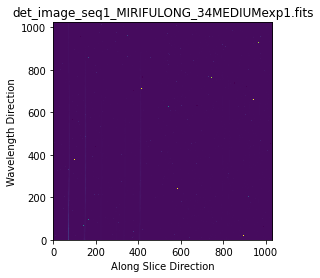

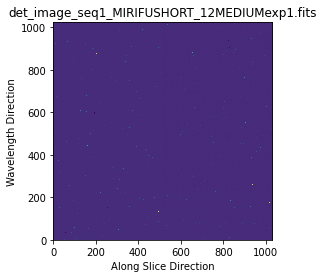

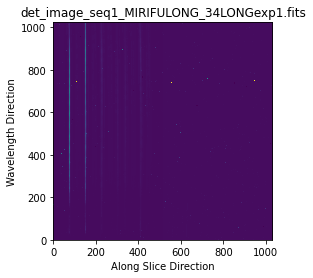

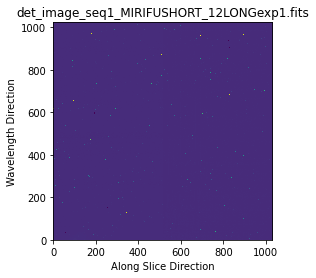

In [23]:
### Loop for all simulations  - SML for 1/2 and 3/4 
for outputdir in directory_list:
    filenames_det_images = glob.glob('{}/{}/*.fits'.format(outputdir,'det_images')) # Get skycube file
    
    for det_images_file in filenames_det_images:
        
        hdulist = fits.open(det_images_file) # Open file 

        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data

        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest')
        plt.title('{}'.format(det_images_file.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')
        plt.show()
        plt.close()

## The outputs of MIRISim can now be run through the JWST pipeline see:
###  https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/